In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import string
import random
from tqdm import tqdm

# PyTorch and Transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from transformers import BertTokenizer, BertModel

# Sklearn metrics and NLTK utilities
from sklearn.metrics import classification_report, confusion_matrix
from nltk import ngrams

# Optional: WordCloud for additional visualization
try:
    from wordcloud import WordCloud
except ImportError:
    print("WordCloud library is not installed. Run 'pip install wordcloud' to use this feature.")

# Set a fixed seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)


In [2]:
import pandas as pd

df = pd.read_csv(
    '/content/AI_Human.csv',
    engine='python',
    on_bad_lines='skip'
)
df.head()


,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [6]:
# Split the dataframe based on the 'generated' flag (0: Human, 1: AI)
df_human = df[df['generated'] == 0]
df_ai = df[df['generated'] == 1]

# Determine the sample size for each class (up to 50k samples per class)
sample_size = min(50000, len(df_human), len(df_ai))
df_human_sampled = df_human.sample(sample_size, random_state=1)
df_ai_sampled = df_ai.sample(sample_size, random_state=1)

# Concatenate the sampled data and reset index
df = pd.concat([df_human_sampled, df_ai_sampled]).reset_index(drop=True)
print(f'Number of rows in data subset: {len(df)}')


Number of rows in data subset: 2072


In [7]:
# Display an example text
print("Example text:\n", df.iloc[0]['text'])

Example text:
 The Risk of Texting and Driving

Over the last few years, texting or talking on the phone has been a rising problem for drivers. According to the National Safety Council, 1.6 million crashes a year are caused by cell phone use, and because of this, I believe cell phone usage should be banned for those operating a vehicle.

In 2106 alone, 263 teenagers were killed because of cell phone usage while driving. Some of these deaths were not even the teenagers fault, but instead because of a distracted driver crashing into them. Even though texting and driving causes so many deaths, the NHTSA has reported that approximately 660,000 drivers use electronic devices while driving every single day. Why would people continue to use cell phones while driving every day when they know how much of a risk there is? I believe it is for one of two main reasons. Either they are impatient or they aren't worried because they don't think it will happen to them.

As for being impatient, I unders

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Maximum token length for the tokenizer: 512


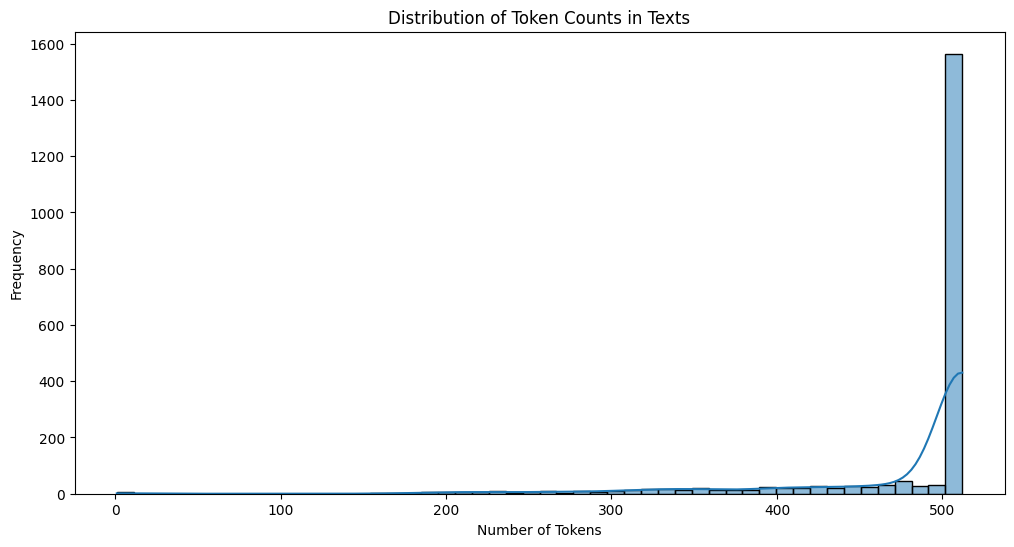

Maximum tokens in a text: 512
95th percentile of token counts: 512.0


In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = tokenizer.model_max_length
print(f'Maximum token length for the tokenizer: {max_length}')

# Creating a copy of the dataframe for visualization purposes
df_vis = df.copy()

def tokenize_and_truncate(text, max_len):
    tokens = tokenizer.tokenize(text)
    return tokens[:max_len]

# Apply tokenization
df_vis['tokens'] = df_vis['text'].apply(lambda x: tokenize_and_truncate(x, max_length))
df_vis['num_tokens'] = df_vis['tokens'].apply(len)

# --- Visualization Section ---


# 1. Distribution of Number of Tokens using a histogram and a Seaborn distplot
plt.figure(figsize=(12, 6))
sns.histplot(df_vis['num_tokens'], bins=50, kde=True)
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Token Counts in Texts')
plt.show()


print(f"Maximum tokens in a text: {df_vis['num_tokens'].max()}")
print(f"95th percentile of token counts: {df_vis['num_tokens'].quantile(0.95)}")

<ipython-input-9-82cc3d42cc5e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(tokens), y=list(counts), palette='viridis')


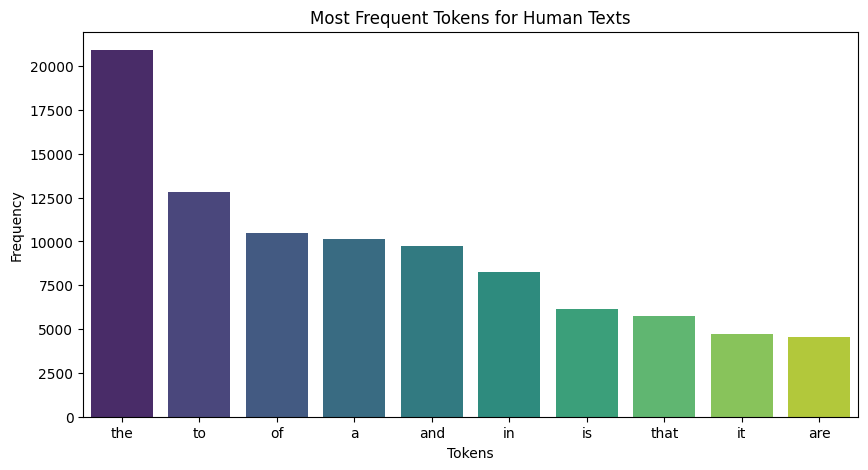

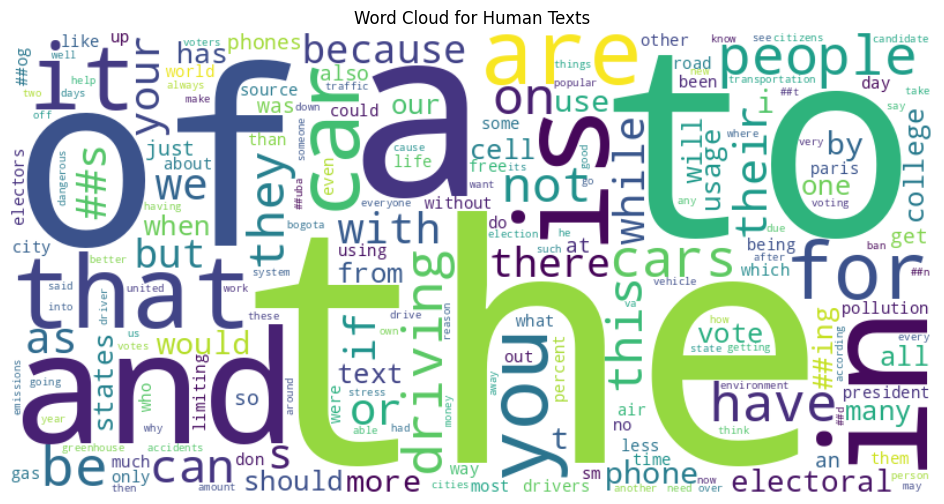

<ipython-input-9-82cc3d42cc5e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(tokens), y=list(counts), palette='viridis')


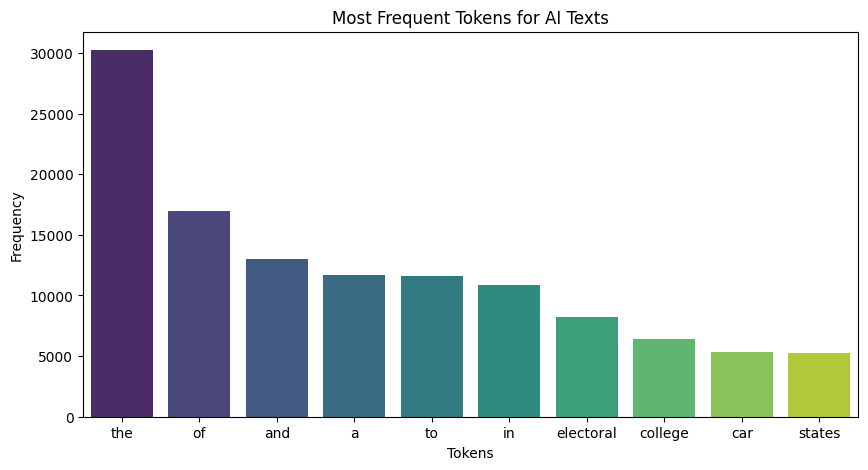

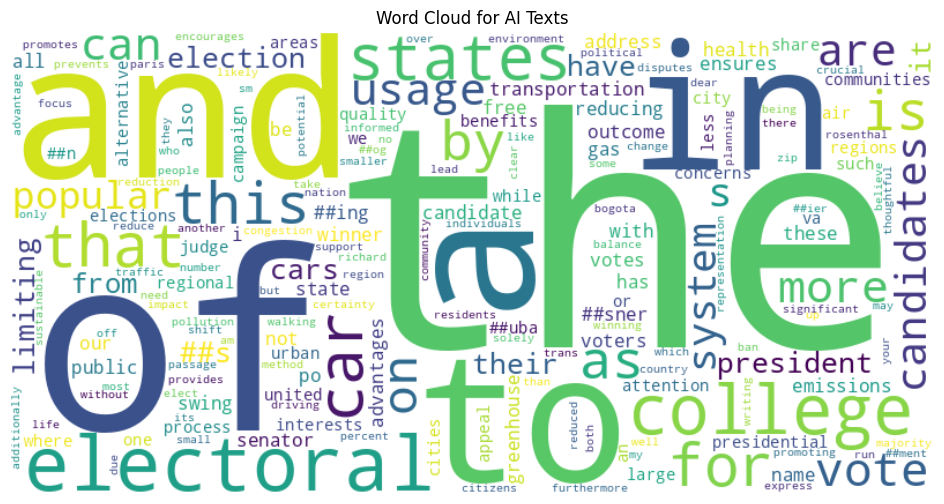

In [9]:
def plot_common_tokens(data, class_label):
    label_map = {0: 'Human', 1: 'AI'}
    subset = data[data['generated'] == class_label]
    # Filter out punctuation tokens
    tokens_list = [token for tokens in subset['tokens'] for token in tokens if token not in string.punctuation]
    token_counter = Counter(tokens_list)
    common = token_counter.most_common(10)

    tokens, counts = zip(*common)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(tokens), y=list(counts), palette='viridis')
    plt.title(f'Most Frequent Tokens for {label_map[class_label]} Texts')
    plt.xlabel('Tokens')
    plt.ylabel('Frequency')
    plt.show()

    # Optional: Generate a word cloud for the same tokens
    try:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(token_counter)
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {label_map[class_label]} Texts')
        plt.show()
    except Exception as e:
        print("WordCloud visualization skipped:", e)

# Plot common tokens for Human and AI texts
plot_common_tokens(df_vis, 0)
plot_common_tokens(df_vis, 1)

<ipython-input-11-2b57cec5e71f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(ngram_labels), y=list(counts), palette='magma')


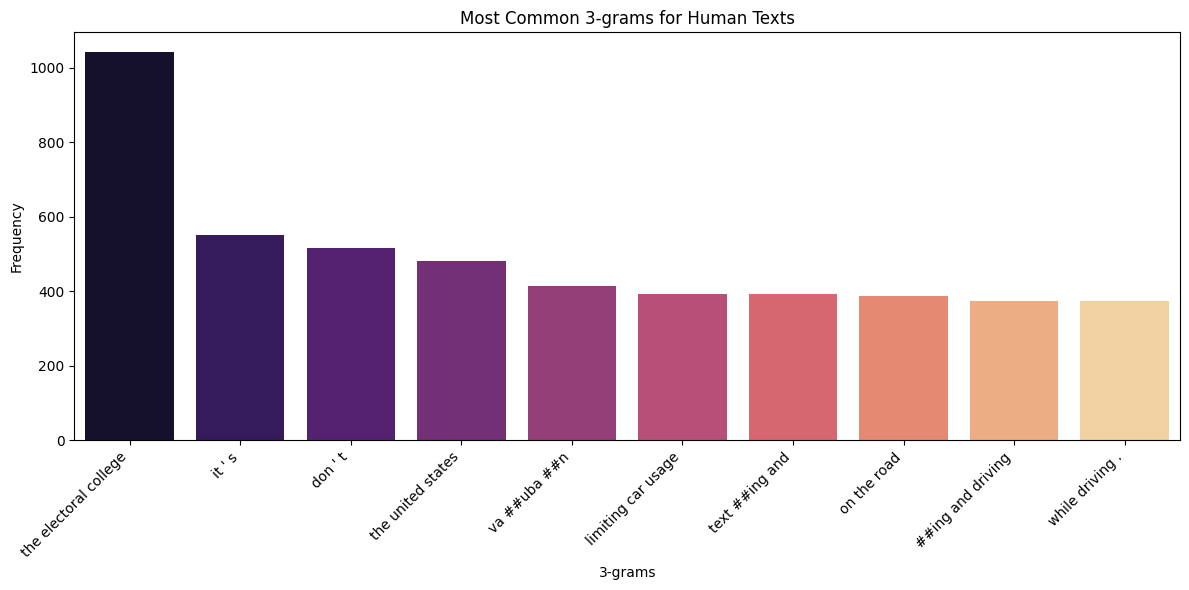

<ipython-input-11-2b57cec5e71f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(ngram_labels), y=list(counts), palette='magma')


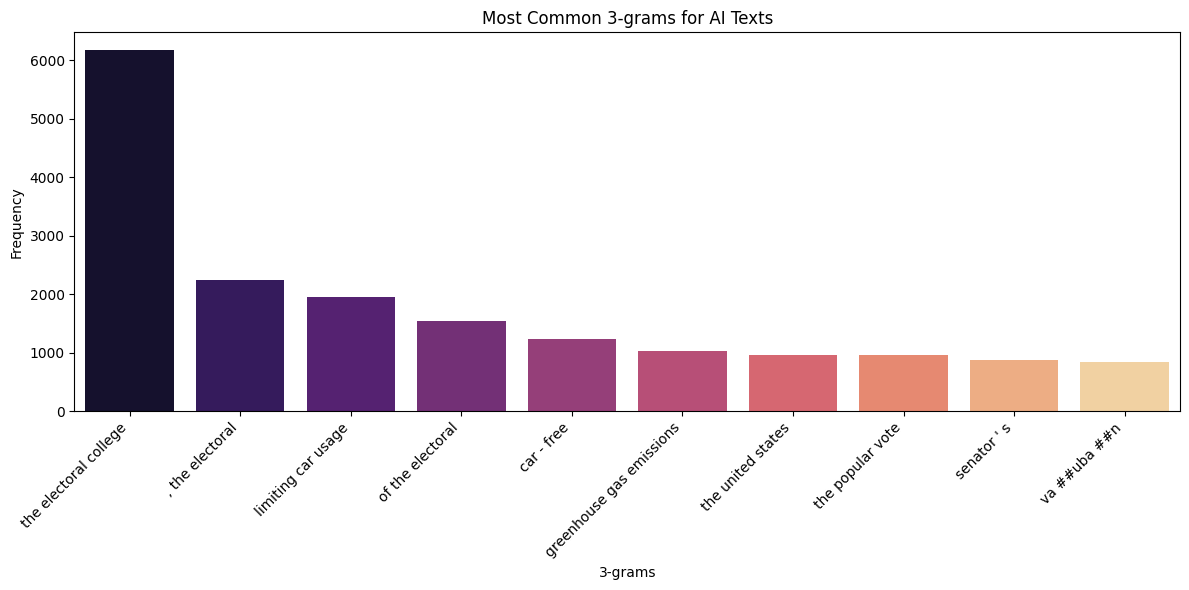

Original Sentence:
Hello, This is Team Future Layoff. We love AI and we'd love to work at OpenAI or Google Deepmind!

Tokens:
['hello', ',', 'this', 'is', 'team', 'future', 'lay', '##off', '.', 'we', 'love', 'ai', 'and', 'we', "'", 'd', 'love', 'to', 'work', 'at', 'open', '##ai', 'or', 'google', 'deep', '##mind', '!']

Input IDs:
[7592, 1010, 2023, 2003, 2136, 2925, 3913, 7245, 1012, 2057, 2293, 9932, 1998, 2057, 1005, 1040, 2293, 2000, 2147, 2012, 2330, 4886, 2030, 8224, 2784, 23356, 999]


In [11]:

def plot_common_ngrams(data, class_label, n, figsize=(12, 6)):
    label_map = {0: 'Human', 1: 'AI'}
    subset = data[data['generated'] == class_label]

    ngram_counter = Counter()
    for tokens in subset['tokens']:
        if tokens and isinstance(tokens, list) and len(tokens) >= n:
            ngram_counter.update(list(ngrams(tokens, n)))

    if not ngram_counter:
        print(f"No {n}-grams found for {label_map[class_label]}")
        return

    common_ngrams = ngram_counter.most_common(10)
    ngrams_list, counts = zip(*common_ngrams)
    # Create labels from n-grams
    ngram_labels = [' '.join(gram) for gram in ngrams_list]

    plt.figure(figsize=figsize)
    sns.barplot(x=list(ngram_labels), y=list(counts), palette='magma')
    plt.title(f'Most Common {n}-grams for {label_map[class_label]} Texts')
    plt.xlabel(f'{n}-grams')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot trigrams for both classes
plot_common_ngrams(df_vis, 0, 3)
plot_common_ngrams(df_vis, 1, 3)

# 4. Demonstration of Tokenization for a Sample Sentence
original_sentence = "Hello, This is Team Future Layoff. We love AI and we'd love to work at OpenAI or Google Deepmind!"
tokens = tokenizer.tokenize(original_sentence)
input_ids = tokenizer.convert_tokens_to_ids(tokens)

print("Original Sentence:")
print(original_sentence)
print("\nTokens:")
print(tokens)
print("\nInput IDs:")
print(input_ids)

dffdsfds

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# -----------------------------------------------------------------------------
# Dataset Definition
# -----------------------------------------------------------------------------
class TextDataset(Dataset):
    """
    Custom Dataset to handle text data tokenization and target extraction.
    """
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = dataframe.generated
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        # Clean the text input: collapse multiple spaces into a single space.
        text = str(self.text[index])
        text = " ".join(text.split())

        # Tokenize, add special tokens, pad/truncate to max_len.
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']

        # Compute the actual length of the sequence (ignoring padding)
        text_length = len([token for token in ids if token != self.tokenizer.pad_token_id])

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float),
            'text_lengths': torch.tensor(text_length, dtype=torch.long)
        }

# Create the dataset instance
dataset = TextDataset(df, tokenizer, max_length)

# -----------------------------------------------------------------------------
# Dataloader Creation Function
# -----------------------------------------------------------------------------
def create_data_loaders(dataset, train_prop=0.75, val_prop=0.1, test_prop=0.15, batch_size=256):
    """
    Splits the dataset into training, validation, and test sets and creates dataloaders.
    """
    total_len = len(dataset)
    train_len = int(train_prop * total_len)
    val_len = int(val_prop * total_len)
    test_len = total_len - train_len - val_len  # Ensure proper split

    # Splitting dataset into train, validation, and test sets
    train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

    # Create DataLoaders with appropriate shuffling
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Generate dataloaders
train_loader, val_loader, test_loader = create_data_loaders(dataset)

# -----------------------------------------------------------------------------
# LSTM Classifier Definition
# -----------------------------------------------------------------------------
class LSTMClassifier(nn.Module):
    """
    A simple LSTM-based classifier for text classification.
    """
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True
        )
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, input_ids: torch.Tensor, ids_len: torch.Tensor) -> torch.Tensor:
        # Convert word indices into embeddings
        embedded = self.embedding(input_ids)

        # Pack the padded sequence. Use enforce_sorted=False if sequences are unsorted.
        packed_embedded = pack_padded_sequence(embedded, ids_len.cpu(), batch_first=True, enforce_sorted=False)

        # Run through the LSTM network
        packed_output, _ = self.lstm(packed_embedded)

        # Unpack back to padded sequences
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Gather the final output of each sequence efficiently
        batch_size = output.size(0)
        last_outputs = output[torch.arange(batch_size), ids_len - 1]

        # Apply dropout and fully connected layer
        dropped = self.dropout(last_outputs)
        logits = self.fc(dropped)

        # Output probabilities (between 0 and 1) using sigmoid activation
        probs = torch.sigmoid(logits).squeeze(1)
        return probs

# -----------------------------------------------------------------------------
# Model Initialization and Summary
# -----------------------------------------------------------------------------
vocab_size = len(tokenizer.vocab)
embedding_dim = 100
hidden_dim = 32

print(f'Vocab size: {vocab_size}')

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim)

def print_model_summary(model):
    """
    Prints a summary of the model architecture and the total number of parameters.
    """
    print('Model Summary:')
    print('--------------------')
    total_params = 0
    for name, parameter in model.named_parameters():
        param = parameter.numel()
        total_params += param
        print(f'{name:25s} {str(list(parameter.shape)):20s} {param:10d}')
    print('--------------------')
    print(f'Total Params: {total_params}')

print_model_summary(model)


Vocab size: 30522
Model Summary:
--------------------
embedding.weight          [30522, 100]            3052200
lstm.weight_ih_l0         [128, 100]                12800
lstm.weight_hh_l0         [128, 32]                  4096
lstm.bias_ih_l0           [128]                       128
lstm.bias_hh_l0           [128]                       128
fc.weight                 [1, 32]                      32
fc.bias                   [1]                           1
--------------------
Total Params: 3069385


**Training The Model**

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------------------------------------------------------
# Training Loop Function
# -----------------------------------------------------------------------------
def train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0

        # Using tqdm for clear progress tracking
        train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch')
        for batch in train_progress_bar:
            optimizer.zero_grad()

            # Sort by sequence lengths (necessary for RNN-based models)
            text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
            ids = batch['ids'][sorted_idx].to(device)
            targets = batch['targets'][sorted_idx].to(device)

            # Forward pass (supports both LSTMClassifier and other models)
            if hasattr(model, 'lstm'):
                predictions = model(ids, text_lengths)
            else:
                predictions = model(ids)

            loss = criterion(predictions, targets)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            train_progress_bar.set_postfix({'loss': f'{loss.item():.3f}'})

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_loss, total_correct, total_labels = 0.0, 0, 0

        with torch.no_grad():
            for batch in val_loader:
                text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
                ids = batch['ids'][sorted_idx].to(device)
                targets = batch['targets'][sorted_idx].to(device)

                if hasattr(model, 'lstm'):
                    predictions = model(ids, text_lengths)
                else:
                    predictions = model(ids)

                loss = criterion(predictions, targets)
                batch_size = ids.size(0)
                total_loss += loss.item() * batch_size
                total_correct += (predictions.round() == targets).sum().item()
                total_labels += batch_size

        avg_loss = total_loss / total_labels
        avg_acc = total_correct / total_labels
        val_losses.append(avg_loss)
        val_accuracies.append(avg_acc)

        print(f"Epoch {epoch+1}/{epochs} - Val Loss: {avg_loss:.3f} - Val Acc: {avg_acc:.3f}")

    return train_losses, val_losses, val_accuracies

# -----------------------------------------------------------------------------
# Evaluation Function
# -----------------------------------------------------------------------------
def evaluate_model(test_loader, model, criterion, device):
    model.eval()
    total_loss, total_correct, total_labels = 0, 0, 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
            ids = batch['ids'][sorted_idx].to(device)
            targets = batch['targets'][sorted_idx].to(device)

            # Support both LSTM and other models
            if hasattr(model, 'lstm'):
                predictions = model(ids, text_lengths)
            else:
                predictions = model(ids)

            loss = criterion(predictions, targets)
            total_loss += loss.item() * ids.size(0)
            total_correct += (predictions.round() == targets).sum().item()
            total_labels += ids.size(0)

            all_predictions.extend(predictions.round().cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_loss = total_loss / total_labels
    avg_acc = total_correct / total_labels
    print(f"Test Loss: {avg_loss:.3f}, Test Accuracy: {avg_acc:.3f}")
    print("\nClassification Report:\n", classification_report(all_targets, all_predictions))

    conf_matrix = confusion_matrix(all_targets, all_predictions)
    return avg_loss, avg_acc, conf_matrix

Using device: cpu


Epoch 1/5: 100%|██████████| 7/7 [04:05<00:00, 35.03s/batch, loss=0.713]


Epoch 1/5 - Val Loss: 0.681 - Val Acc: 0.575


Epoch 2/5: 100%|██████████| 7/7 [03:36<00:00, 30.92s/batch, loss=0.612]


Epoch 2/5 - Val Loss: 0.674 - Val Acc: 0.560


Epoch 3/5: 100%|██████████| 7/7 [03:56<00:00, 33.77s/batch, loss=0.597]


Epoch 3/5 - Val Loss: 0.668 - Val Acc: 0.575


Epoch 4/5: 100%|██████████| 7/7 [03:48<00:00, 32.64s/batch, loss=0.616]


Epoch 4/5 - Val Loss: 0.666 - Val Acc: 0.570


Epoch 5/5: 100%|██████████| 7/7 [04:17<00:00, 36.80s/batch, loss=0.511]


Epoch 5/5 - Val Loss: 0.667 - Val Acc: 0.580


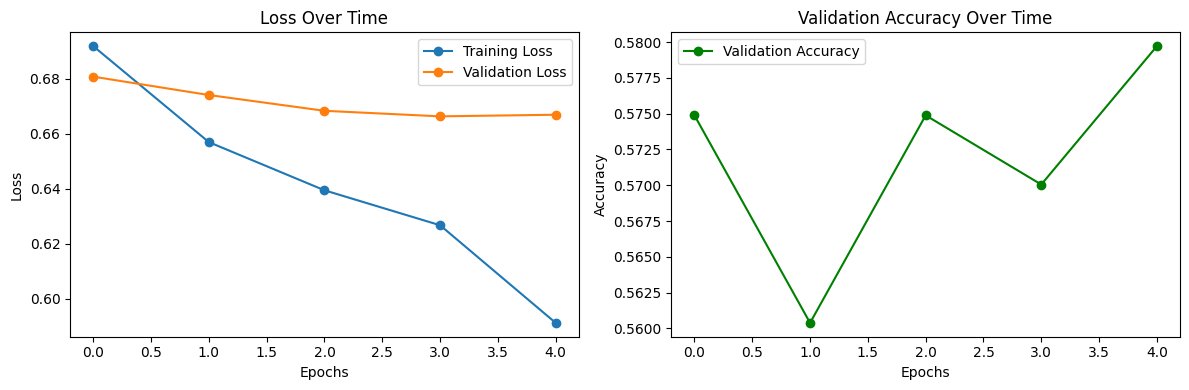

Test Loss: 0.661, Test Accuracy: 0.624

Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.53      0.59       156
         1.0       0.60      0.72      0.65       155

    accuracy                           0.62       311
   macro avg       0.63      0.62      0.62       311
weighted avg       0.63      0.62      0.62       311



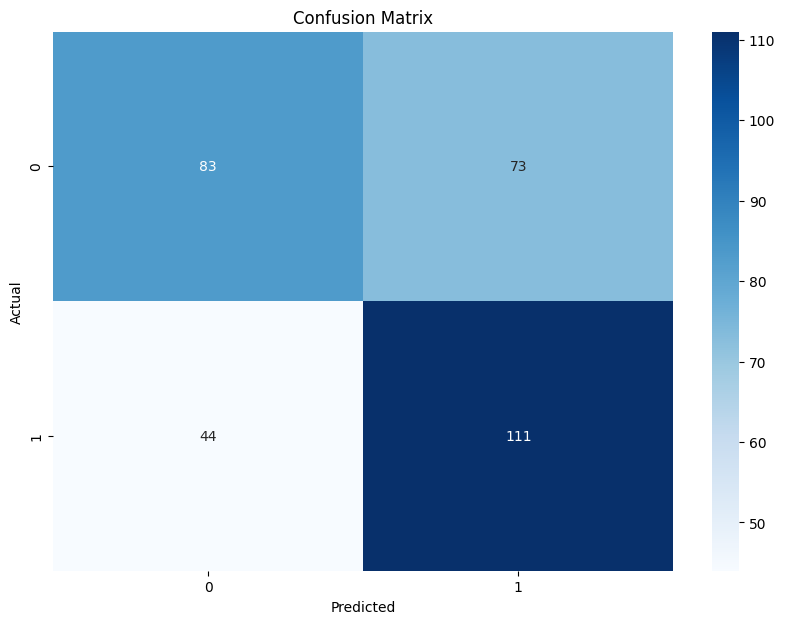

In [22]:
# -----------------------------------------------------------------------------
# LSTM Training, Evaluation, and Visualization
# -----------------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Define loss and optimizer (for the LSTM model assumed to be defined earlier)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

# Move model and criterion to device
model = model.to(device)
criterion = criterion.to(device)

# Set epochs
epochs = 5

# Train the LSTM model
train_losses, val_losses, val_accuracies = train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device)

# Plot training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Time')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the LSTM model on the test set
test_loss, test_acc, conf_matrix = evaluate_model(test_loader, model, criterion, device)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Model Summary:
--------------------
embedding.weight          [30522, 300]            9156600
conv1d_list.0.weight      [100, 300, 3]             90000
conv1d_list.0.bias        [100]                       100
conv1d_list.1.weight      [200, 300, 4]            240000
conv1d_list.1.bias        [200]                       200
conv1d_list.2.weight      [300, 300, 5]            450000
conv1d_list.2.bias        [300]                       300
fc.weight                 [1, 600]                    600
fc.bias                   [1]                           1
--------------------
Total Params: 9937801


Epoch 1/5: 100%|██████████| 7/7 [02:12<00:00, 18.97s/batch, loss=0.386]


Epoch 1/5 - Val Loss: 0.088 - Val Acc: 1.000


Epoch 2/5: 100%|██████████| 7/7 [02:10<00:00, 18.63s/batch, loss=0.050]


Epoch 2/5 - Val Loss: 0.031 - Val Acc: 0.995


Epoch 3/5: 100%|██████████| 7/7 [02:28<00:00, 21.19s/batch, loss=0.021]


Epoch 3/5 - Val Loss: 0.021 - Val Acc: 0.995


Epoch 4/5: 100%|██████████| 7/7 [02:16<00:00, 19.53s/batch, loss=0.059]


Epoch 4/5 - Val Loss: 0.013 - Val Acc: 0.995


Epoch 5/5: 100%|██████████| 7/7 [02:09<00:00, 18.53s/batch, loss=0.005]


Epoch 5/5 - Val Loss: 0.007 - Val Acc: 1.000


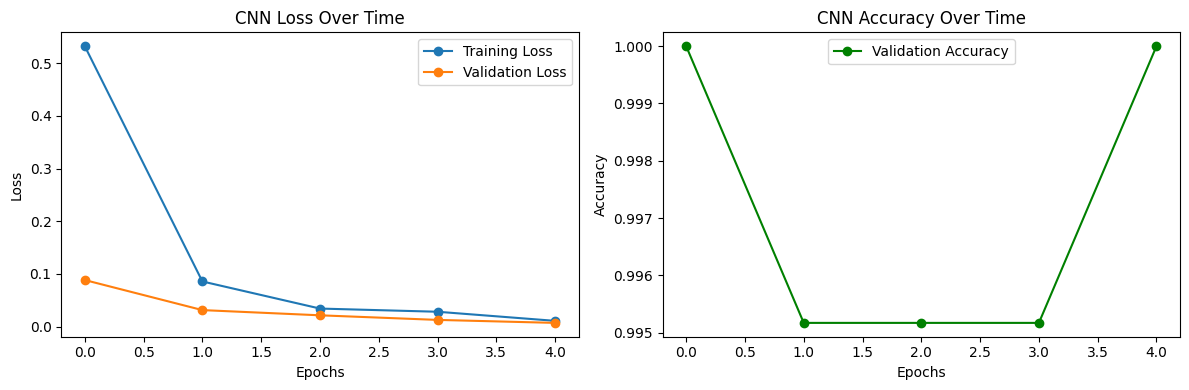

Test Loss: 0.026, Test Accuracy: 0.994

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       156
         1.0       1.00      0.99      0.99       155

    accuracy                           0.99       311
   macro avg       0.99      0.99      0.99       311
weighted avg       0.99      0.99      0.99       311



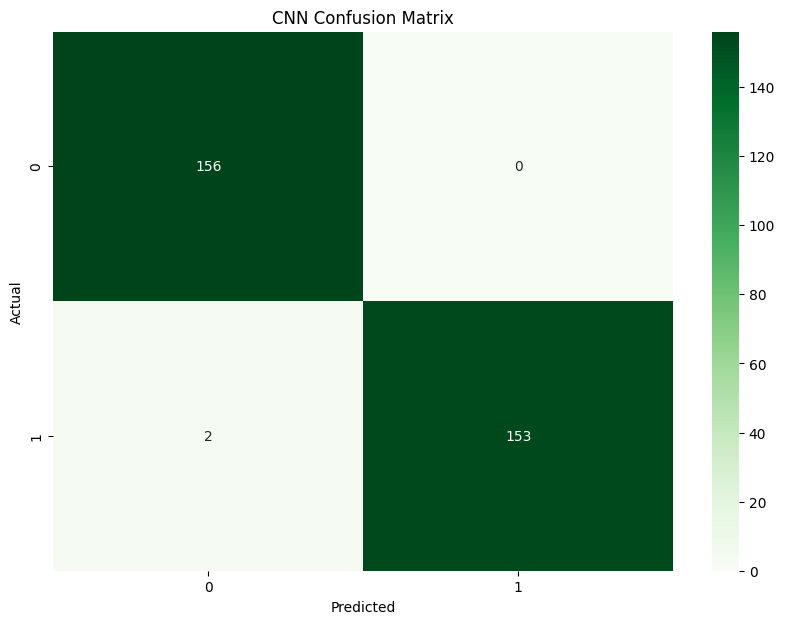

In [23]:
# -----------------------------------------------------------------------------
# CNN Classifier Definition and Training
# -----------------------------------------------------------------------------
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, pad_idx, embedding_dim, filter_sizes, num_filters, num_classes):
        super(CNNClassifier, self).__init__()
        # Embedding layer with padding index
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_dim,
                                      padding_idx=pad_idx)
        # Convolutional layers for different filter sizes
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully connected layer
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, input_ids):
        # Convert input ids to embeddings
        ids_embedded = self.embedding(input_ids).float()
        # Permute dimensions to (batch, embedding_dim, sequence_length)
        ids_reshaped = ids_embedded.permute(0, 2, 1)
        # Apply convolution + ReLU for each filter size
        ids_conv_list = [F.relu(conv(ids_reshaped)) for conv in self.conv1d_list]
        # Apply max pooling over time (kernel size equals conv output length)
        ids_pool_list = [F.max_pool1d(conv_out, kernel_size=conv_out.shape[2])
                         for conv_out in ids_conv_list]
        # Concatenate pooled outputs
        ids_fc = torch.cat([pool.squeeze(dim=2) for pool in ids_pool_list], dim=1)
        # Apply dropout and final classification layer
        logits = self.fc(self.dropout(ids_fc))
        # Squeeze and apply sigmoid activation for binary classification
        return torch.sigmoid(logits).squeeze(1)

# Initialize the CNN model
pad_idx = tokenizer.pad_token_id
vocab_size = len(tokenizer.vocab)
num_classes = 1
embedding_dim = 300
filter_sizes = [3, 4, 5]
num_filters = [100, 200, 300]

cnn_model = CNNClassifier(vocab_size, pad_idx, embedding_dim, filter_sizes, num_filters, num_classes)
cnn_model = cnn_model.to(device)
print_model_summary(cnn_model)

# Reset optimizer and criterion for CNN training
optimizer = torch.optim.Adam(cnn_model.parameters())
criterion = nn.BCELoss().to(device)
epochs = 5

# Train the CNN model
train_losses, val_losses, val_accuracies = train_model(epochs, train_loader, val_loader, cnn_model, criterion, optimizer, device)

# Visualize training progress for CNN
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Loss Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Accuracy Over Time')
plt.legend()
plt.tight_layout()
plt.show()

# Final evaluation of the CNN model on the test set
test_loss, test_acc, conf_matrix = evaluate_model(test_loader, cnn_model, criterion, device)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN Confusion Matrix')
plt.show()